In [1]:
import numpy as np
import netCDF4 as nc 
import matplotlib.pyplot as plt 
import matplotlib.dates as pltd
import datetime as dt
import pandas
import xarray as xr
import xesmf as xe

In [2]:
area_fid = nc.Dataset('areacello_Ofx_GFDL-ESM4_historical_r1i1p1f1_gr.nc')
area = area_fid.variables['areacello'][:]
lsm = area>0

lon = area_fid.variables['lon'][:]
lat = area_fid.variables['lat'][:]
lons,lats = np.meshgrid(lon,lat)
ocean_lons = lons[lsm].ravel()
ocean_lats = lats[lsm].ravel()

depth_fid = nc.Dataset('deptho_Ofx_GFDL-ESM4_historical_r1i1p1f1_gr.nc')
depth = depth_fid.variables['deptho'][:]
depth.fill_value=0

woa_fid = nc.Dataset('/work/Liz.Drenkard/external_data/WOA/1_deg/woa_1x1deg_basin_mask.nc')
woa_mask = woa_fid.variables['basin_mask'][:].squeeze()
# rearrange to go from 0 - 360 longitude to match ESM4 convention
msk_lon = woa_fid.variables['lon'][:]
basin_mask = np.hstack((woa_mask[:,msk_lon>=0],woa_mask[:,msk_lon<0]))
# basin mask: 1= atlantic and arctic, 2 = Pacific, 3 = Indian Oceans

In [3]:
# I start with my dictionaries with all the details I want 
file_dir = '/work/Alison.Novara/'

# For now, this is a dictionary containg the file names. 
#     We can add more to it to include details for plots and analyses
organism_dict = {'scallop':{'title':'A irradians', 'plot_title':'$\it{Argopecten}$ $\it{irradians}$',
                            'geo_index': (depth<700)*(lats>=0)*(lons>250)*(lons<300)*(basin_mask==1),},
                 'pteropod':{'title':'L helicina','plot_title':'$\it{Limacina}$ $\it{helicina}$', 
                             'geo_index': (lats>40)*(depth<1000),},
                 'coral':{'title':'P astreoides','plot_title':'$\it{Porites}$ $\it{astreoides}$',
                          'geo_index': (depth<2000)*(lons>250)*(lons<305)*(basin_mask==1),}}

scenario_dict = {'2061-2100_ssp126':{'label':'ssp126','bar_color':'navy'},
                 '2061-2100_ssp245':{'label':'ssp245','bar_color':'orange'},
                 '2061-2100_ssp370':{'label':'ssp370','bar_color':'red'},
                 '2061-2100_ssp585':{'label':'ssp585','bar_color':'maroon'}}


scallop
1220051000000.0
2061-2100_ssp126
2061-2100_ssp245
2061-2100_ssp370
2061-2100_ssp585
pteropod
13176540000000.0
2061-2100_ssp126
2061-2100_ssp245
2061-2100_ssp370
2061-2100_ssp585
coral
1984635300000.0
2061-2100_ssp126
2061-2100_ssp245
2061-2100_ssp370
2061-2100_ssp585


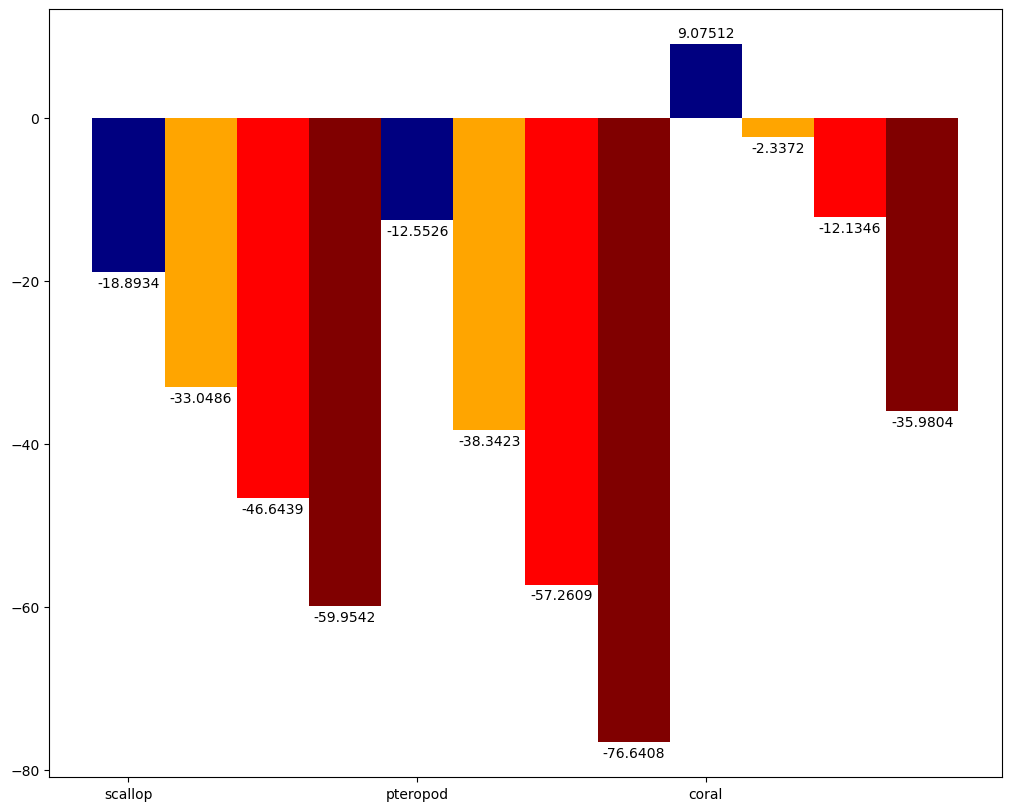

In [4]:
# Define figure object
fig, ax = plt.subplots(layout='constrained',figsize=(10,8))

x = np.arange(len(organism_dict))  # the label locations
width = 0.25  # the width of the bars

for organism,norg in zip(organism_dict,range(len(organism_dict))):
    print(organism)
    multiplier = 0
    # import historical data for temp and saturation state
    thetao_ncfile = 'thetao_1975-2014_his.nc'
    # create the netCDF file id 
    thetao_fid = nc.Dataset(thetao_ncfile)
    # extract the variable from the netcdf file. 
    surf_temp = thetao_fid.variables['thetao'][:,0,:,:].squeeze()
    surf_temp_mean = np.mean(surf_temp,axis=0)   
    surf_temp_mean.fill_value = 0
 
    # Read in the carbonate chemistry files - we're starting with the historical period
    ksp_fid = nc.Dataset('co3satarag_1975-2014_his.nc')
    co3_fid = nc.Dataset('co3_1975-2014_his.nc')

    # extract the variable from the netcdf file. 
    co3sat = ksp_fid.variables['co3satarag'][:].squeeze()
    co3 = co3_fid.variables['co3'][:].squeeze()

    # just using the surface
    surf_co3sat = co3sat[:,0,:,:]
    surf_co3 = co3[:,0,:,:]

    # calculating aragonite saturation state:
    #    co3/co3sat = arag saturation state 
    surf_arag_sat = np.mean(surf_co3/surf_co3sat,axis=0)
    surf_arag_sat.fill_value = 0
    
    if organism == 'scallop':
        enviro_index = (surf_arag_sat>2)*(surf_temp_mean<28)*(surf_temp_mean>11)
        
    elif organism == 'pteropod':
        enviro_index = (surf_arag_sat>1)*(surf_temp_mean<12)
        
    else:
        enviro_index = (surf_arag_sat>2)*(surf_temp_mean<29)*(surf_temp_mean>25)
        
    
    habitat_index = organism_dict[organism]['geo_index']*enviro_index
    
    his_total_habitat_area = np.sum(area[habitat_index]) 
    
    print(his_total_habitat_area)
    
    for scenario in scenario_dict:
        print(scenario)
        thetao_ncfile = 'thetao_' + scenario + '.nc'
        # create the netCDF file id 
        thetao_fid = nc.Dataset(thetao_ncfile)
        # extract the variable from the netcdf file. 
        surf_temp = thetao_fid.variables['thetao'][:,0,:,:].squeeze()
        surf_temp_mean = np.mean(surf_temp,axis=0)   
        surf_temp_mean.fill_value = 0
       
        # Read in the carbonate chemistry files - we're starting with the historical period
        ksp_fid = nc.Dataset(('co3satarag_' + scenario +'.nc'))
        co3_fid = nc.Dataset('co3_' + scenario + '.nc')

        # extract the variable from the netcdf file. 
        co3sat = ksp_fid.variables['co3satarag'][:].squeeze()
        co3 = co3_fid.variables['co3'][:].squeeze()

        # just using the surface
        surf_co3sat = co3sat[:,0,:,:]
        surf_co3 = co3[:,0,:,:]

        # calculating aragonite saturation state:
        #    co3/co3sat = arag saturation state 
        surf_arag_sat = np.mean(surf_co3/surf_co3sat,axis=0)
        surf_arag_sat.fill_value = 0
        
        # Redefine index values with future diagnostic values
        if organism == 'scallop':
            enviro_index = (surf_arag_sat>2)*(surf_temp_mean<28)*(surf_temp_mean>11)
        
        elif organism == 'pteropod':
            enviro_index = (surf_arag_sat>1)*(surf_temp_mean<12)
        
        else:
            enviro_index = (surf_arag_sat>2)*(surf_temp_mean<29)*(surf_temp_mean>25)
        
        habitat_index = organism_dict[organism]['geo_index']*enviro_index
        
        fut_total_habitat_area = np.sum(area[habitat_index])
        
        percent_change = 100 * ((fut_total_habitat_area - his_total_habitat_area)/his_total_habitat_area)
        
        # plot scenario bar for given organism
        offset = width * multiplier
        rects = ax.bar(x[norg] + offset, percent_change, width, color=scenario_dict[scenario]['bar_color'], label=scenario_dict[scenario]['label'])
        ax.bar_label(rects, padding=3)
        multiplier += 1
        
    ax.set_xticks(x)
    ax.set_xticklabels(organism_dict.keys())
    
    ax.set_label('Organisms')

#plt.savefig('test_percent_change_scenaros')